# 해상물류비용 분야 문제

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import norm, skew

In [2]:
logistic_cost = pd.read_excel('.\해상수출물류비용 분야 - 코머신\A. 20피트 청구서.xlsx')

In [3]:
logistic_cost_dup = logistic_cost
logistic_cost_dup.head(7)

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계
0,2014-01-01,NYK PHOENIX 50E52,KRPUS,DNA,ESDNA,1,3260.0,1071.3,3492438,115000,4350,30000,3641788
1,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582
2,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822
3,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344
4,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710
5,2014-01-03,BARENTS STRAIT QB599S,KRINC,SGN,VNSGN,1,750.0,1064.4,798300,116000,4350,30000,948650
6,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610


---
## Preprocessing
1. [NA value 제거](#na-value-제거)
2. [중복값 제거](#중복값-제거)
3. [부산항 제외 출발항구 제거](#부산항-제외-출발항구-제거)

#### 1. NA value 제거

In [4]:
logistic_cost_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15514 entries, 0 to 15513
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ONBOARD      15514 non-null  object 
 1   VESSEL       15514 non-null  object 
 2   POL          15514 non-null  object 
 3   NATION       15514 non-null  object 
 4   DESTINATION  15514 non-null  object 
 5   20`          15514 non-null  int64  
 6   RATE         15514 non-null  float64
 7   EX-RATE      15514 non-null  float64
 8   O/FRT KRW    15514 non-null  int64  
 9   THC          15514 non-null  int64  
 10  W/F          15514 non-null  int64  
 11  D/FEE        15514 non-null  int64  
 12  합계           15514 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 1.5+ MB


위의 결과를 통해 전처리해야할 NA 값은 없음을 알 수 있음

#### 2. 중복값 제거

In [5]:
logistic_cost_dup.drop_duplicates()
logistic_cost_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15514 entries, 0 to 15513
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ONBOARD      15514 non-null  object 
 1   VESSEL       15514 non-null  object 
 2   POL          15514 non-null  object 
 3   NATION       15514 non-null  object 
 4   DESTINATION  15514 non-null  object 
 5   20`          15514 non-null  int64  
 6   RATE         15514 non-null  float64
 7   EX-RATE      15514 non-null  float64
 8   O/FRT KRW    15514 non-null  int64  
 9   THC          15514 non-null  int64  
 10  W/F          15514 non-null  int64  
 11  D/FEE        15514 non-null  int64  
 12  합계           15514 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 1.5+ MB


drop_duplicates를 실행했으나 entry의 수에는 변함이 없으므로 중목값이 없다는 것도 알 수 있음

#### 3. 부산항 제외 출발항구 제거

이번 과제에선 부산항발 물류만 분석하기로 했으므로 부산항 외 항구는 제거해줌

In [6]:
Pusan = logistic_cost_dup['POL'].str.contains('KRPUS|KRBUS|KRPUP')

logistic_cost_dup = logistic_cost_dup[Pusan]

logistic_cost_dup = logistic_cost_dup.reset_index(drop = True)

logistic_cost_dup['POL'].value_counts()

KRPUS    14155
KRBUS      370
KRPUP       62
Name: POL, dtype: int64

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
## 문제 1. 상위 10개 수출항구를 정리해 2014~2020년까지 물류비용 데이터를 월별로 시각화하시오
* 월별 시각화를 위해 연-월-일 순으로 저장돼있는 ONBOARD 데이터를 연과 월로 나눈다

In [7]:
# ONBOARD_Y = []

# for i in range(len(logistic_cost_dup['ONBOARD'])):
#     ONBOARD_Y.append(logistic_cost_dup['ONBOARD'][i][0:4])
    
# logistic_cost_dup['ONBOARD_Y'] = ONBOARD_Y
# logistic_cost_dup

In [8]:
# ONBOARD_M = []

# for i in range(len(logistic_cost_dup['ONBOARD'])):
#     ONBOARD_M.append(logistic_cost_dup['ONBOARD'][i][5:7])
    
# logistic_cost_dup['ONBOARD_M'] = ONBOARD_M
# logistic_cost_dup

In [9]:
#logistic_cost_dup = logistic_cost_dup[['ONBOARD_Y', 'ONBOARD_M', 'POL', 'DESTINATION', 'RATE', 'EX-RATE', 'O/FRT KRW', 'THC', 'W/F', 'D/FEE', '합계']]

In [7]:
top_10 = logistic_cost_dup['DESTINATION'].value_counts()[:10]

In [8]:
logistic_cost_dup['DESTINATION'].value_counts()[:20]

USLGB    1660
USLAX    1223
USNYC    1086
USHOU     748
USDET     609
USCHI     587
HKHKG     464
USOAK     356
IDJKT     243
UYSTY     237
USSAV     232
JPOSA     204
DEHAM     202
USCHS     195
USBAL     195
CATOR     182
MXZLO     163
USATL     162
USMIA     160
USBOS     157
Name: DESTINATION, dtype: int64

In [9]:
top_10_records = logistic_cost_dup['DESTINATION'].isin(top_10.index)
top_10_logistic_cost = logistic_cost_dup[top_10_records]
top_10_logistic_cost = top_10_logistic_cost.reset_index(drop = True)
top_10_logistic_cost #top10 레코드 완성

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071


In [10]:
top_10_logistic_cost['date_dt'] = pd.to_datetime(top_10_logistic_cost['ONBOARD'])
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29


In [11]:
top_10_logistic_cost.to_excel(excel_writer = 'top 10 물류 비용 (2).xlsx', index = False)

In [ ]:
# 합계
# monthly_logistic_cost_tot = top_10_logistic_cost.groupby(['ONBOARD_Y', 'ONBOARD_M'])['합계'].sum()
# monthly_logistic_cost_tot

# 합계 - 시각화
# monthly_logistic_cost_tot.plot(kind = 'bar', figsize = (20,10))

# 운임비용
# monthly_logistic_rate = top_10_logistic_cost.groupby(['ONBOARD_Y', 'ONBOARD_M'])['O/FRT KRW'].sum()
# monthly_logistic_rate

# 운임비용 - 시각화
# monthly_logistic_rate.plot(kind = 'bar', figsize = (20,10))

# 부대비용
# top_10_logistic_cost['부대비용'] = top_10_logistic_cost['THC'] + top_10_logistic_cost['W/F'] + top_10_logistic_cost['D/FEE']
# top_10_logistic_cost
# monthly_logistic_fare = top_10_logistic_cost.groupby(['ONBOARD_Y', 'ONBOARD_M'])['부대비용'].sum()
# monthly_logistic_fare

# 부대비용 - 시각화
# monthly_logistic_fare.plot(kind = 'bar', figsize = (20,10))

#### 문제 2. 상위 10개 수출항구에 대한 2014~2020년까지 월별 가격 데이터 평균화하시오.

### 해당 data frame을 문제 2 까지 사용하였으며, 시각화는 powerBI 사용


ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
## 문제 3. 연도별로 수출물류비용에 영향을 미치는 요소를 정리하고 요소에 대한 변동 값을 구해 위 데이터 분석에 적용해 증명하시오

* 컨테이너 가격 영향 요소
 1. 물류상황 (물동량, 공컨테이너량)
 2. 코로나 영향 (확진자 수)
 3. [SCFI](#scfi-preprocessing-및-합병)


* 환율 영향 요소
 1. [KOSPI](#kospi-preprocessing-및-합병)
 2. [두바이유 가격](#두바이유-preprocessing-및-합병)
 3. [GDP](#gdp-preprocessing-및-합병)

#### 물동량 preprocessing 및 합병

In [11]:
amount = pd.read_csv('.\외부 데이터\\amount.csv')
amount

,년도,물동량,증감율,수출입_소계,수입,수출,환적_소계,환적_점유율,환적_증감율,연안
0,2013,17686,0.038,8933,4424,4509,8748,0.495,0.074,4.0
1,2014,18683,0.056,9238,4589,4649,9429,0.505,0.078,NaN
2,2015,19469,0.042,9364,4714,4650,10105,0.519,0.072,NaN
3,2016,19456,-0.001,9620,4801,4819,9836,0.506,-0.027,NaN
4,2017,20493,0.053,10186,5042,5144,10225,0.499,0.040,82.0
5,2018,21663,0.057,10233,5117,5116,11429,0.528,0.110,NaN
6,2019,21990,1.509,10354,5280,5074,11636,0.529,1.810,NaN
7,2020,21813,-0.800,9803,4852,4951,12020,0.551,3.300,NaN


In [12]:
amount.drop(columns=['연안','환적_점유율','환적_소계','환적_증감율','증감율','수입','수출'], inplace=True)
amount = amount.drop(amount.index[0])
#amount.rename(columns = {'수출입_소계' : 'new_nm'}, inplace = True)

amount

,년도,물동량,수출입_소계
1,2014,18683,9238
2,2015,19469,9364
3,2016,19456,9620
4,2017,20493,10186
5,2018,21663,10233
6,2019,21990,10354
7,2020,21813,9803


In [13]:
amount_list = []

#없는 날 고려해야함
for i in top_10_logistic_cost['ONBOARD']:
    if i[0:4] == '2014':
        amount_list.append(9238)
    elif i[0:4] == '2015':
        amount_list.append(9364)
    elif i[0:4] == '2016':
        amount_list.append(9620)
    elif i[0:4] == '2017':
        amount_list.append(10186)
    elif i[0:4] == '2018':
        amount_list.append(10233)  
    elif i[0:4] == '2019':
        amount_list.append(10354)
    elif i[0:4] == '2020':
        amount_list.append(9803)

top_10_logistic_cost['amount'] = amount_list
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803


#### 코로나 확진자 수 preprocessing 및 합병

In [14]:
covid = pd.read_csv('.\외부 데이터\covid.csv')
covid

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,seq,stdDay,areaNm,areaNmEn,areaNmCn,nationNm,nationNmEn,nationNmCn,natDefCnt,natDeathCnt,natDeathRate,createDt,updateDt
0,1,2020년 3월 09일 00시,아시아,NaN,NaN,중국,NaN,NaN,80735.0,3119.0,3.863256,2020-03-16 20:51,NaN
1,2,2020년 3월 09일 00시,아시아,NaN,NaN,홍콩,NaN,NaN,115.0,2.0,1.73913,2020-03-16 20:51,NaN
2,3,2020년 3월 09일 00시,아시아,NaN,NaN,대만,NaN,NaN,45.0,1.0,2.222222,2020-03-16 20:51,NaN
3,4,2020년 3월 09일 00시,아시아,NaN,NaN,마카오,NaN,NaN,10.0,NaN,0.0,2020-03-16 20:51,NaN
4,5,2020년 3월 09일 00시,아시아,NaN,NaN,일본,NaN,NaN,488.0,7.0,1.434426,2020-03-16 20:51,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101369,115095,2021년 08월 06일 09시,아프리카,Africa,非洲,남수단,South Sudan,南蘇丹,11090.0,120.0,1.082055906,2021-08-06 11:13,NaN
101370,115096,2021년 08월 06일 09시,아프리카,Africa,非洲,상투메프린시페,Sao Tome and Principe,聖多美和普林西比,2463.0,37.0,1.502233049,2021-08-06 11:13,NaN
101371,115097,2021년 08월 06일 09시,아프리카,Africa,非洲,코모로,Comoros,科摩羅,4029.0,147.0,3.648548027,2021-08-06 11:13,NaN
101372,115098,2021년 08월 06일 09시,아프리카,Africa,非洲,레소토,Lesotho,萊索托,13603.0,377.0,2.771447475,2021-08-06 11:13,NaN


In [15]:
covid.drop(columns=['seq','areaNmEn','areaNmCn','nationNmEn','nationNmCn','createDt','updateDt','natDeathCnt','natDeathRate'], inplace=True)

In [16]:
covid.rename(columns = {"stdDay": "기준일시"}, inplace = True)
covid.rename(columns = {"areaNm": "지역명"}, inplace = True)
covid.rename(columns = {"nationNm": "국가명"}, inplace = True)
covid.rename(columns = {"natDefCnt": "국가별 확진자 수"}, inplace = True)

covid['date_dt']=pd.to_datetime(covid['기준일시'], format='%Y년 %m월 %d일 %H시')

covid = covid.astype({'date_dt': 'string'})

covid

,기준일시,지역명,국가명,국가별 확진자 수,date_dt
0,2020년 3월 09일 00시,아시아,중국,80735.0,2020-03-09 00:00:00
1,2020년 3월 09일 00시,아시아,홍콩,115.0,2020-03-09 00:00:00
2,2020년 3월 09일 00시,아시아,대만,45.0,2020-03-09 00:00:00
3,2020년 3월 09일 00시,아시아,마카오,10.0,2020-03-09 00:00:00
4,2020년 3월 09일 00시,아시아,일본,488.0,2020-03-09 00:00:00
...,...,...,...,...,...
101369,2021년 08월 06일 09시,아프리카,남수단,11090.0,2021-08-06 09:00:00
101370,2021년 08월 06일 09시,아프리카,상투메프린시페,2463.0,2021-08-06 09:00:00
101371,2021년 08월 06일 09시,아프리카,코모로,4029.0,2021-08-06 09:00:00
101372,2021년 08월 06일 09시,아프리카,레소토,13603.0,2021-08-06 09:00:00


In [17]:
hong = covid.loc[covid['국가명'] == '홍콩',['국가명','국가별 확진자 수','date_dt']]
ind = covid.loc[covid['국가명'] == '인도네시아',['국가명','국가별 확진자 수','date_dt']]
usa = covid.loc[covid['국가명'] == '미국',['국가명','국가별 확진자 수','date_dt']]
uru = covid.loc[covid['국가명'] == '우루과이',['국가명','국가별 확진자 수','date_dt']]

top10_covid = pd.concat([hong,ind,usa,uru], axis=0, ignore_index = True)

top10_covid

,국가명,국가별 확진자 수,date_dt
0,홍콩,115.0,2020-03-09 00:00:00
1,홍콩,116.0,2020-03-10 09:00:00
2,홍콩,121.0,2020-03-11 09:00:00
3,홍콩,130.0,2020-03-12 09:00:00
4,홍콩,131.0,2020-03-13 09:00:00
...,...,...,...
2131,우루과이,380976.0,2021-07-31 09:00:00
2132,우루과이,381517.0,2021-08-03 09:00:00
2133,우루과이,381569.0,2021-08-04 09:00:00
2134,우루과이,381715.0,2021-08-05 09:00:00


In [18]:
top10_covid.isna().sum()

국가명          0
국가별 확진자 수    0
date_dt      0
dtype: int64

In [19]:
new_case = np.zeros(len(top10_covid))

for i in range(1,len(top10_covid)):
    if top10_covid['국가명'][i] == top10_covid['국가명'][i-1]:
        new_case[i] = top10_covid['국가별 확진자 수'][i] - top10_covid['국가별 확진자 수'][i-1]

In [20]:
top10_covid['일별 신규 확진자 수'] = new_case

In [22]:
for i in range(len(top10_covid['date_dt'])):
    top10_covid['date_dt'][i] = top10_covid['date_dt'][i][0:10]
    
top10_covid

,국가명,국가별 확진자 수,date_dt,일별 신규 확진자 수
0,홍콩,115.0,2020-03-09,0.0
1,홍콩,116.0,2020-03-10,1.0
2,홍콩,121.0,2020-03-11,5.0
3,홍콩,130.0,2020-03-12,9.0
4,홍콩,131.0,2020-03-13,1.0
...,...,...,...,...
2131,우루과이,380976.0,2021-07-31,183.0
2132,우루과이,381517.0,2021-08-03,541.0
2133,우루과이,381569.0,2021-08-04,52.0
2134,우루과이,381715.0,2021-08-05,146.0


In [23]:
nation = []

for i in top_10_logistic_cost['DESTINATION']:
    if i[0:2] == 'US':
        nation.append('미국')
    elif i[0:2] == 'UY':
        nation.append('우루과이')
    elif i[0:2] == 'HK':
        nation.append('홍콩')
    elif i[0:2] == 'ID':
        nation.append('인도네시아')

top_10_logistic_cost['국가'] = nation
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount,국가
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238,미국
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238,미국
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238,미국
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238,미국
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238,미국
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803,미국
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803,미국
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803,미국
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803,미국


In [24]:
top_10_logistic_cost['날짜와 국가'] = top_10_logistic_cost['ONBOARD'] + ' ' + top_10_logistic_cost['국가']
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount,국가,날짜와 국가
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238,미국,2014-01-01 미국
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238,미국,2014-01-02 미국
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238,미국,2014-01-02 미국
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238,미국,2014-01-02 미국
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238,미국,2014-01-03 미국
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803,미국,2020-09-28 미국
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803,미국,2020-09-28 미국
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803,미국,2020-09-28 미국
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803,미국,2020-09-29 미국


In [25]:
top10_covid['날짜와 국가'] = top10_covid['date_dt'] + ' ' + top10_covid['국가명']
top10_covid

,국가명,국가별 확진자 수,date_dt,일별 신규 확진자 수,날짜와 국가
0,홍콩,115.0,2020-03-09,0.0,2020-03-09 홍콩
1,홍콩,116.0,2020-03-10,1.0,2020-03-10 홍콩
2,홍콩,121.0,2020-03-11,5.0,2020-03-11 홍콩
3,홍콩,130.0,2020-03-12,9.0,2020-03-12 홍콩
4,홍콩,131.0,2020-03-13,1.0,2020-03-13 홍콩
...,...,...,...,...,...
2131,우루과이,380976.0,2021-07-31,183.0,2021-07-31 우루과이
2132,우루과이,381517.0,2021-08-03,541.0,2021-08-03 우루과이
2133,우루과이,381569.0,2021-08-04,52.0,2021-08-04 우루과이
2134,우루과이,381715.0,2021-08-05,146.0,2021-08-05 우루과이


In [26]:
top_10_logistic_cost_new_case_col = np.zeros(len(top_10_logistic_cost['날짜와 국가']))

for i in range(len(top_10_logistic_cost['날짜와 국가'])):
    for j in range(len(top10_covid['날짜와 국가'])):
        if top_10_logistic_cost['날짜와 국가'][i] == top10_covid['날짜와 국가'][j]:
            top_10_logistic_cost_new_case_col[i] = top10_covid['일별 신규 확진자 수'][j]
            break

In [27]:
top_10_logistic_cost['일별 신규 확진자 수'] = top_10_logistic_cost_new_case_col

In [28]:
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238,미국,2014-01-01 미국,0.0
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238,미국,2014-01-02 미국,0.0
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238,미국,2014-01-02 미국,0.0
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238,미국,2014-01-02 미국,0.0
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238,미국,2014-01-03 미국,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803,미국,2020-09-28 미국,50070.0
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803,미국,2020-09-28 미국,50070.0
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803,미국,2020-09-28 미국,50070.0
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803,미국,2020-09-29 미국,48958.0


In [44]:
# data = pd.merge(top_10_logistic_cost, top10_covid, 
#                   how='left', left_on = '날짜와 국가', right_on = '날짜와 국가')
# data

In [32]:
#new_case_list = np.zeros(len(top_10_logistic_cost['ONBOARD']))

#for i in range(len(top_10_logistic_cost['ONBOARD'])):
#    if date in top10_covid['date_dt']:
#        if top_10_logistic_cost['DESTINATION'][i][0:2] == 'US':
#            country = '미국'
#        elif top_10_logistic_cost['DESTINATION'][i][0:2] == 'UY':
#            country= '우루과이'
#        elif top_10_logistic_cost['DESTINATION'][i][0:2] == 'HK':
#            country= '홍콩'
#        elif top_10_logistic_cost['DESTINATION'][i][0:2] == 'ID':
#            country= '인도네시아'
#        _row = top10_covid[(top10_covid['date_dt'] == date) & (top10_covid['국가명'] == country)].index[0]
#        new_case_list_component = top10_covid[(top10_covid['date_dt'] == date) & (top10_covid['국가명'] == country)]['일별 신규 확진자 수'][_row]
#        new_case_list[i] = new_case_list_component

#top_10_logistic_cost['일별 신규 확진자 수'] = new_case_list

#top_10_logistic_cost 

#### SCFI preprocessing 및 합병

In [29]:
scfi = pd.read_csv('.\외부 데이터\scfi.csv')
scfi = scfi.transpose()
scfi = scfi.reset_index()
scfi

,index,0,1,2
0,Date,ALL,CCFI,SCFI
1,2014,01월 02일,1098.37,1176.12
2,2014.1,01월 09일,1115.55,1167.53
3,2014.2,01월 16일,1128.73,1188.44
4,2014.3,01월 23일,1148.37,1173.99
...,...,...,...,...
386,2021.28,07월 23일,2854.02,4100
387,2021.29,07월 30일,2930.03,4196.24
388,2021.30,08월 06일,3006.82,4225.86
389,2021.31,08월 13일,2978.47,4281.53


In [30]:
# 첫 번째 행 삭제
scfi = scfi.drop([scfi.index[0]])

# 칼럼 이름 변경
scfi.rename(columns = {'index':'date1'}, inplace=True)
scfi.rename(columns = {0:'date2'}, inplace=True)
scfi.rename(columns = {1:'CCFI'}, inplace=True)
scfi.rename(columns = {2:'SCFI'}, inplace=True)

scfi = scfi.reset_index(drop=True)

scfi

,date1,date2,CCFI,SCFI
0,2014,01월 02일,1098.37,1176.12
1,2014.1,01월 09일,1115.55,1167.53
2,2014.2,01월 16일,1128.73,1188.44
3,2014.3,01월 23일,1148.37,1173.99
4,2014.4,01월 30일,1158.16,1168.25
...,...,...,...,...
385,2021.28,07월 23일,2854.02,4100
386,2021.29,07월 30일,2930.03,4196.24
387,2021.30,08월 06일,3006.82,4225.86
388,2021.31,08월 13일,2978.47,4281.53


In [31]:
for i in range(4, 10):
    for j in range(1, 60):
        scfi['date1'] = scfi['date1'].replace('201%d.%d'%(i,j), '201%d년'%(i))

for i in range(4, 10):
        scfi['date1'] = scfi['date1'].replace('201%d'%(i), '201%d년'%(i))
        
for i in range(0, 2):
    for j in range(1, 60):
        scfi['date1'] = scfi['date1'].replace('202%d.%d'%(i,j), '202%d년'%(i))

for i in range(0, 2):
        scfi['date1'] = scfi['date1'].replace('202%d'%(i), '202%d년'%(i))
        
scfi

,date1,date2,CCFI,SCFI
0,2014년,01월 02일,1098.37,1176.12
1,2014년,01월 09일,1115.55,1167.53
2,2014년,01월 16일,1128.73,1188.44
3,2014년,01월 23일,1148.37,1173.99
4,2014년,01월 30일,1158.16,1168.25
...,...,...,...,...
385,2021년,07월 23일,2854.02,4100
386,2021년,07월 30일,2930.03,4196.24
387,2021년,08월 06일,3006.82,4225.86
388,2021년,08월 13일,2978.47,4281.53


In [32]:
scfi['date'] = scfi['date1'] + " " + scfi['date2']
scfi = scfi[['date', 'SCFI']]
scfi

,date,SCFI
0,2014년 01월 02일,1176.12
1,2014년 01월 09일,1167.53
2,2014년 01월 16일,1188.44
3,2014년 01월 23일,1173.99
4,2014년 01월 30일,1168.25
...,...,...
385,2021년 07월 23일,4100
386,2021년 07월 30일,4196.24
387,2021년 08월 06일,4225.86
388,2021년 08월 13일,4281.53


In [33]:
scfi['SCFI'] = pd.to_numeric(scfi['SCFI'])

<ipython-input-33-30d2a70e52dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scfi['SCFI'] = pd.to_numeric(scfi['SCFI'])


In [34]:
#결측치 확인
scfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    390 non-null    object 
 1   SCFI    390 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.2+ KB


In [35]:
scfi.describe()

,SCFI
count,390.000000
mean,1088.947385
std,746.827485
min,400.430000
25%,758.857500
50%,856.835000
75%,1053.277500
max,4340.180000


{'whiskers': [<matplotlib.lines.Line2D at 0x1929b717790>,
 'caps': [<matplotlib.lines.Line2D at 0x1929b717e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1929b717430>],
 'medians': [<matplotlib.lines.Line2D at 0x1929b72d550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1929b72d8b0>],
 'means': []}

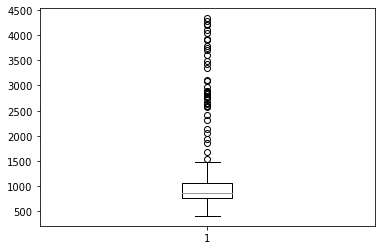

In [36]:
#이상치 탐지
plt.boxplot(scfi['SCFI'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SCFI', ylabel='Density'>

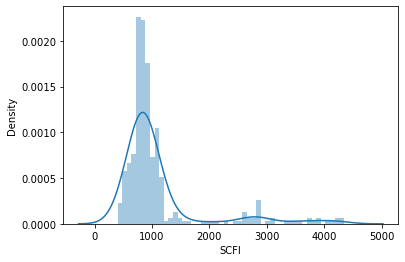

In [37]:
#정규성 확인
sns.distplot(scfi['SCFI'])

In [38]:
scfi['SCFI'].skew()

2.6954609328713106

In [39]:
scfi['SCFI'].kurt()

6.78241552283404

In [40]:
#정규화
scfi['SCFI_boxcox'] = preprocessing.scale(boxcox(scfi['SCFI']+1)[0])

<ipython-input-40-ff390c7b3a13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scfi['SCFI_boxcox'] = preprocessing.scale(boxcox(scfi['SCFI']+1)[0])


In [41]:
scfi['SCFI_boxcox'].skew()

-0.05580981135126101

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SCFI_boxcox', ylabel='Density'>

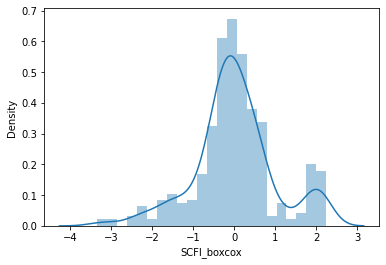

In [42]:
sns.distplot(scfi['SCFI_boxcox'])

In [44]:
for i in range(len(scfi['date'])):
    date = scfi['date'][i][0:4] + '-' + scfi['date'][i][6:8] + '-' + scfi['date'][i][10:12]
    scfi['date'][i] = date
    
scfi

<ipython-input-44-bbe461ea6a3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scfi['date'][i] = date
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,date,SCFI,SCFI_boxcox
0,2014-01-02,1176.12,0.730093
1,2014-01-09,1167.53,0.714697
2,2014-01-16,1188.44,0.751784
3,2014-01-23,1173.99,0.726296
4,2014-01-30,1168.25,0.715996
...,...,...,...
385,2021-07-23,4100.00,2.211776
386,2021-07-30,4196.24,2.225292
387,2021-08-06,4225.86,2.229327
388,2021-08-13,4281.53,2.236758


In [ ]:
# data = pd.merge(data, scfi, 
#                   how='left', left_on = 'ONBOARD', right_on = 'date')
# data

In [45]:
scifi_boxcox = []

#없는 날 고려해야함
for i in top_10_logistic_cost['ONBOARD']:
    for j in range(len(scfi['date'])):
        if i == scfi['date'][j]:
            scifi_boxcox.append(scfi['SCFI_boxcox'][j])
            break
        if i != scfi['date'][j] and j == (len(scfi['date'])-1):
            scifi_boxcox.append('no value')

top_10_logistic_cost['SCFI_boxcox'] = scifi_boxcox
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수,SCFI_boxcox
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238,미국,2014-01-01 미국,0.0,no value
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238,미국,2014-01-03 미국,0.0,no value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803,미국,2020-09-28 미국,50070.0,no value
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803,미국,2020-09-28 미국,50070.0,no value
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803,미국,2020-09-28 미국,50070.0,no value
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803,미국,2020-09-29 미국,48958.0,no value


In [46]:
top_10_logistic_cost['SCFI_boxcox'][0] = top_10_logistic_cost['SCFI_boxcox'][1]

<ipython-input-46-56eb624cfbb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['SCFI_boxcox'][0] = top_10_logistic_cost['SCFI_boxcox'][1]


In [47]:
for i in range(len(top_10_logistic_cost['SCFI_boxcox'])):
    if top_10_logistic_cost['SCFI_boxcox'][i] == 'no value':
        j = 1
        while(True):
            if top_10_logistic_cost['SCFI_boxcox'][i+j] != 'no value':
                top_10_logistic_cost['SCFI_boxcox'][i] = top_10_logistic_cost['SCFI_boxcox'][i+j]
                break
            elif top_10_logistic_cost['SCFI_boxcox'][i-j] != 'no value':
                top_10_logistic_cost['SCFI_boxcox'][i] = top_10_logistic_cost['SCFI_boxcox'][i-j]
                break
            else:
                j += 1
                
top_10_logistic_cost

<ipython-input-47-6d753eb8b4fb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['SCFI_boxcox'][i] = top_10_logistic_cost['SCFI_boxcox'][i-j]
<ipython-input-47-6d753eb8b4fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['SCFI_boxcox'][i] = top_10_logistic_cost['SCFI_boxcox'][i+j]


,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수,SCFI_boxcox
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238,미국,2014-01-01 미국,0.0,0.730093
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238,미국,2014-01-03 미국,0.0,0.730093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803,미국,2020-09-29 미국,48958.0,1.117209


### KOSPI preprocessing 및 합병

In [49]:
kospi = pd.read_csv('.\외부 데이터\코스피 200 내역 (1).csv')

In [50]:
kospi = kospi.sort_values(by=['날짜']).reset_index(drop=True)
kospi

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2014년 01월 02일,257.64,264.35,264.51,257.63,64.00K,-2.50%
1,2014년 01월 03일,254.48,257.05,257.29,253.18,62.39K,-1.23%
2,2014년 01월 06일,255.41,254.70,256.67,254.11,59.08K,0.37%
3,2014년 01월 07일,255.98,254.53,257.02,254.41,60.98K,0.22%
4,2014년 01월 08일,255.76,256.85,257.06,254.63,66.03K,-0.09%
...,...,...,...,...,...,...,...
1715,2020년 12월 23일,371.32,367.02,371.93,364.72,296.02M,1.33%
1716,2020년 12월 24일,379.18,371.67,380.29,371.67,314.37M,2.12%
1717,2020년 12월 28일,379.93,381.51,383.84,378.44,304.33M,0.20%
1718,2020년 12월 29일,381.27,380.34,382.31,377.04,234.72M,0.35%


In [51]:
kospi['mean'] = (kospi['종가'] + kospi['오픈'] + kospi['고가'] + kospi['저가']) / 4

In [52]:
## 불필요한 columns 삭제
drop_kospi = ['종가', '오픈', '고가', '저가', '거래량', '변동 %']
kospi = kospi.drop(drop_kospi, axis=1)

In [54]:
#결측치 확인
kospi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720 entries, 0 to 1719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      1720 non-null   object 
 1   mean    1720 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.0+ KB


In [55]:
kospi.describe()

,mean
count,1720.000000
mean,275.106390
std,29.786677
min,202.000000
25%,252.363125
50%,267.350000
75%,296.470000
max,384.920000


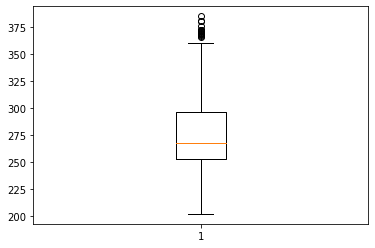

In [56]:
# 이상치 탐지
plt.boxplot(kospi['mean'])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean', ylabel='Density'>

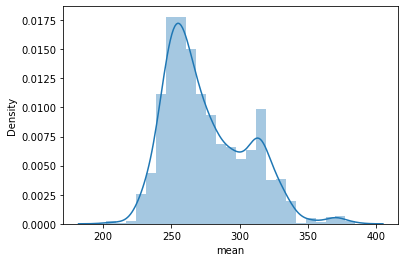

In [57]:
#정규성 확인
sns.distplot(kospi['mean'])

In [58]:
kospi['mean'].skew()

0.7407013799233936

In [59]:
kospi['mean'].kurt()

0.04681173993049814

In [60]:
# 정규화
kospi_log = np.log1p(kospi['mean'])

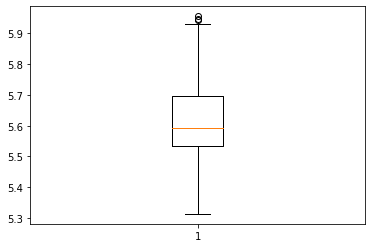

In [61]:
plt.boxplot(kospi_log)
plt.show()

In [62]:
kospi_log.skew()

0.5192801667817702

In [63]:
kospi['mean_log']= np.log1p(kospi['mean'])
kospi

,날짜,mean,mean_log
0,2014년 01월 02일,261.0325,5.568469
1,2014년 01월 03일,255.5000,5.547129
2,2014년 01월 06일,255.2225,5.546046
3,2014년 01월 07일,255.4850,5.547070
4,2014년 01월 08일,256.0750,5.549368
...,...,...,...
1715,2020년 12월 23일,368.7475,5.912820
1716,2020년 12월 24일,375.7025,5.931456
1717,2020년 12월 28일,380.9300,5.945237
1718,2020년 12월 29일,380.2400,5.943429


In [64]:
for i in range(len(kospi['날짜'])):
    date = kospi['날짜'][i][0:4] + '-' + kospi['날짜'][i][6:8] + '-' + kospi['날짜'][i][10:12]
    kospi['날짜'][i] = date

<ipython-input-64-cb5b9c2c7de9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kospi['날짜'][i] = date


In [ ]:
data = pd.merge(data, kospi, 
                  how='left', left_on = 'ONBOARD', right_on = '날짜')
data

In [66]:
KOSPI_mean_log = []

#없는 날 고려해야함
for i in top_10_logistic_cost['ONBOARD']:
    for j in range(len(kospi['날짜'])):
        if i == kospi['날짜'][j]:
            KOSPI_mean_log.append(kospi['mean_log'][j])
            break
        if i != kospi['날짜'][j] and j == (len(kospi['날짜'])-1):
            KOSPI_mean_log.append('no value')

top_10_logistic_cost['KOSPI_mean_log'] = KOSPI_mean_log
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수,SCFI_boxcox,KOSPI_mean_log
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238,미국,2014-01-01 미국,0.0,0.730093,no value
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238,미국,2014-01-03 미국,0.0,0.730093,5.547129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803,미국,2020-09-29 미국,48958.0,1.117209,5.739238


In [67]:
top_10_logistic_cost['KOSPI_mean_log'][0] = top_10_logistic_cost['KOSPI_mean_log'][1]
top_10_logistic_cost['KOSPI_mean_log'][7212] = top_10_logistic_cost['KOSPI_mean_log'][7211]
top_10_logistic_cost

<ipython-input-67-63b555ba377a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['KOSPI_mean_log'][0] = top_10_logistic_cost['KOSPI_mean_log'][1]
<ipython-input-67-63b555ba377a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['KOSPI_mean_log'][7212] = top_10_logistic_cost['KOSPI_mean_log'][7211]


,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,합계,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수,SCFI_boxcox,KOSPI_mean_log
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,4350,30000,4401582,2014-01-01,9238,미국,2014-01-01 미국,0.0,0.730093,5.568469
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,4350,30000,3067822,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,4350,30000,3130344,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,4350,30000,3569710,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,4350,30000,1641610,2014-01-03,9238,미국,2014-01-03 미국,0.0,0.730093,5.547129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,4420,50000,1957270,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,4420,40000,3595119,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,4420,50000,3799732,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,4420,50000,3686071,2020-09-29,9803,미국,2020-09-29 미국,48958.0,1.117209,5.739238


In [68]:
for i in range(len(top_10_logistic_cost['KOSPI_mean_log'])):
    if top_10_logistic_cost['KOSPI_mean_log'][i] == 'no value':
        j = 1
        while(True):
            if top_10_logistic_cost['KOSPI_mean_log'][i+j] != 'no value':
                top_10_logistic_cost['KOSPI_mean_log'][i] = top_10_logistic_cost['KOSPI_mean_log'][i+j]
                break
            elif top_10_logistic_cost['KOSPI_mean_log'][i-j] != 'no value':
                top_10_logistic_cost['KOSPI_mean_log'][i] = top_10_logistic_cost['KOSPI_mean_log'][i-j]
                break
            else:
                j += 1

<ipython-input-68-f4b204d4043d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['KOSPI_mean_log'][i] = top_10_logistic_cost['KOSPI_mean_log'][i-j]
<ipython-input-68-f4b204d4043d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['KOSPI_mean_log'][i] = top_10_logistic_cost['KOSPI_mean_log'][i+j]


In [69]:
sum(top_10_logistic_cost['KOSPI_mean_log'] == 'no value')

0

### 두바이유 preprocessing 및 합병

In [71]:
dubai = pd.read_csv('.\외부 데이터\두바이유 내역.csv')
dubai

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2020년 12월 31일,49.81,49.81,49.81,49.81,-,0.00%
1,2020년 12월 30일,49.82,49.82,49.82,49.82,-,0.07%
2,2020년 12월 29일,49.78,49.78,49.78,49.78,-,0.01%
3,2020년 12월 28일,49.77,49.77,49.77,49.77,-,-0.13%
4,2020년 12월 24일,49.84,49.84,49.84,49.84,-,0.04%
...,...,...,...,...,...,...,...
1675,2014년 05월 02일,104.00,104.00,104.00,104.00,-,0.00%
1676,2014년 05월 01일,104.00,104.00,104.00,104.00,-,0.00%
1677,2014년 04월 30일,104.00,104.00,104.00,104.00,-,0.00%
1678,2014년 04월 29일,104.00,104.00,104.00,104.00,-,0.00%


In [72]:
dubai['mean'] = (dubai['종가'] + dubai['오픈'] + dubai['고가'] + dubai['저가']) / 4

drop_dubai = ['종가', '오픈', '고가', '저가', '거래량', '변동 %']
dubai = dubai.drop(drop_dubai, axis=1)
dubai

,날짜,mean
0,2020년 12월 31일,49.81
1,2020년 12월 30일,49.82
2,2020년 12월 29일,49.78
3,2020년 12월 28일,49.77
4,2020년 12월 24일,49.84
...,...,...
1675,2014년 05월 02일,104.00
1676,2014년 05월 01일,104.00
1677,2014년 04월 30일,104.00
1678,2014년 04월 29일,104.00


In [73]:
#결측치 확인
dubai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      1680 non-null   object 
 1   mean    1680 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.4+ KB


위의 결과를 통해 전처리해야할 NA 값은 없음을 알 수 있음

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean', ylabel='Density'>

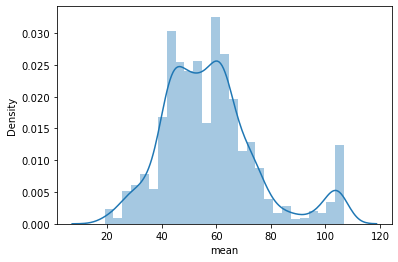

In [74]:
#정규성 확인
sns.distplot(dubai['mean'])

In [75]:
dubai['mean'].skew()

0.8558347901666843

히스토그램이 왼쪽으로 쏠려있어 정규성을 만족하지 못하고 있음

로그화로 정규화 진행

In [76]:
#정규화
dubai_log = np.log1p(dubai['mean'])
dubai_log.skew()

-0.17246610833663692

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean', ylabel='Density'>

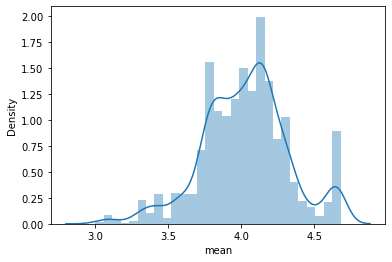

In [77]:
sns.distplot(dubai_log)

In [78]:
dubai['mean_log']= dubai_log
dubai

,날짜,mean,mean_log
0,2020년 12월 31일,49.81,3.928093
1,2020년 12월 30일,49.82,3.928290
2,2020년 12월 29일,49.78,3.927503
3,2020년 12월 28일,49.77,3.927306
4,2020년 12월 24일,49.84,3.928683
...,...,...,...
1675,2014년 05월 02일,104.00,4.653960
1676,2014년 05월 01일,104.00,4.653960
1677,2014년 04월 30일,104.00,4.653960
1678,2014년 04월 29일,104.00,4.653960


In [79]:
for i in range(len(dubai['날짜'])):
    date = dubai['날짜'][i][0:4] + '-' + dubai['날짜'][i][6:8] + '-' + dubai['날짜'][i][10:12]
    dubai['날짜'][i] = date

dubai = dubai.sort_values(by = ['날짜'], axis = 0)
dubai

<ipython-input-79-534ee96f40e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dubai['날짜'][i] = date


,날짜,mean,mean_log
1679,2014-04-28,104.00,4.653960
1678,2014-04-29,104.00,4.653960
1677,2014-04-30,104.00,4.653960
1676,2014-05-01,104.00,4.653960
1675,2014-05-02,104.00,4.653960
...,...,...,...
4,2020-12-24,49.84,3.928683
3,2020-12-28,49.77,3.927306
2,2020-12-29,49.78,3.927503
1,2020-12-30,49.82,3.928290


In [ ]:
# data = pd.merge(data, dubai, 
#                   how='left', left_on = 'ONBOARD', right_on = '날짜')
# data

In [80]:
dubai_mean_log = []

#없는 날 고려해야함
for i in top_10_logistic_cost['ONBOARD']:
    for j in range(len(dubai['날짜'])):
        if i == dubai['날짜'][j]:
            dubai_mean_log.append(dubai['mean_log'][j])
            break
        if i != dubai['날짜'][j] and j == (len(dubai['날짜'])-1):
            dubai_mean_log.append('no value')

top_10_logistic_cost['dubai_mean_log'] = dubai_mean_log
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,...,D/FEE,합계,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수,SCFI_boxcox,KOSPI_mean_log,dubai_mean_log
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,...,30000,4401582,2014-01-01,9238,미국,2014-01-01 미국,0.0,0.730093,5.568469,no value
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,...,30000,3067822,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,no value
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,...,30000,3130344,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,no value
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,...,30000,3569710,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,no value
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,...,30000,1641610,2014-01-03,9238,미국,2014-01-03 미국,0.0,0.730093,5.547129,no value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,...,50000,1957270,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,...,40000,3595119,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,...,50000,3799732,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,...,50000,3686071,2020-09-29,9803,미국,2020-09-29 미국,48958.0,1.117209,5.739238,3.75021


In [86]:
#top_10_logistic_cost['ONBOARD'][top_10_logistic_cost['ONBOARD'] == '2014-04-28'].index

In [81]:
top_10_logistic_cost['dubai_mean_log'][:209] = top_10_logistic_cost['dubai_mean_log'][210]

<ipython-input-81-dd3c178150a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['dubai_mean_log'][:209] = top_10_logistic_cost['dubai_mean_log'][210]


In [82]:
for i in range(len(top_10_logistic_cost['dubai_mean_log'])):
    if top_10_logistic_cost['dubai_mean_log'][i] == 'no value':
        j = 1
        while(True):
            if top_10_logistic_cost['dubai_mean_log'][i+j] != 'no value':
                top_10_logistic_cost['dubai_mean_log'][i] = top_10_logistic_cost['dubai_mean_log'][i+j]
                break
            elif top_10_logistic_cost['dubai_mean_log'][i-j] != 'no value':
                top_10_logistic_cost['dubai_mean_log'][i] = top_10_logistic_cost['dubai_mean_log'][i-j]
                break
            else:
                j += 1

<ipython-input-82-1f26c70e02c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['dubai_mean_log'][i] = top_10_logistic_cost['dubai_mean_log'][i+j]
<ipython-input-82-1f26c70e02c0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_logistic_cost['dubai_mean_log'][i] = top_10_logistic_cost['dubai_mean_log'][i-j]


In [83]:
sum(top_10_logistic_cost['dubai_mean_log'] == 'no value')

0

### GDP preprocessing 및 합병

In [85]:
GDP = pd.read_excel('.\외부 데이터\GDP_분기별.xls', sheet_name=1)
GDP

,분기,GDP
0,20141/4,"373,559.7"
1,20142/4,"388,566.9"
2,20143/4,"393,425.4"
3,20144/4,"407,377.0"
4,20151/4,"394,273.0"
5,20152/4,"411,386.8"
6,20153/4,"420,790.8"
7,20154/4,"431,569.8"
8,20161/4,"413,482.6"
9,20162/4,"434,462.9"


In [87]:
quarter_list = []

for i in range(len(top_10_logistic_cost['ONBOARD'])):
    if top_10_logistic_cost['ONBOARD'][i][5:7] in ['01','02','03']: #1분기
        quarter_list.append(top_10_logistic_cost['ONBOARD'][i][0:4] + '1')
    elif top_10_logistic_cost['ONBOARD'][i][5:7] in ['04','05','06']: #2분기
        quarter_list.append(top_10_logistic_cost['ONBOARD'][i][0:4] + '2')
    elif top_10_logistic_cost['ONBOARD'][i][5:7] in ['07','08','09']: #3분기
        quarter_list.append(top_10_logistic_cost['ONBOARD'][i][0:4] + '3')
    elif top_10_logistic_cost['ONBOARD'][i][5:7] in ['10','11','12']: #4분기
        quarter_list.append(top_10_logistic_cost['ONBOARD'][i][0:4] + '4')
        
top_10_logistic_cost['quarter'] = quarter_list
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,...,합계,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수,SCFI_boxcox,KOSPI_mean_log,dubai_mean_log,quarter
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,...,4401582,2014-01-01,9238,미국,2014-01-01 미국,0.0,0.730093,5.568469,4.65396,20141
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,...,3067822,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,4.65396,20141
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,...,3130344,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,4.65396,20141
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,...,3569710,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,4.65396,20141
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,...,1641610,2014-01-03,9238,미국,2014-01-03 미국,0.0,0.730093,5.547129,4.65396,20141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,...,1957270,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324,20203
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,...,3595119,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324,20203
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,...,3799732,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324,20203
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,...,3686071,2020-09-29,9803,미국,2020-09-29 미국,48958.0,1.117209,5.739238,3.75021,20203


In [88]:
GDP_list = []

for i in top_10_logistic_cost['quarter']:
    for j in range(len(GDP['분기'])):
        if i == GDP['분기'][j][0:5]:
            GDP_list.append(GDP['GDP'][j])

top_10_logistic_cost['GDP'] = GDP_list
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,20`,RATE,EX-RATE,O/FRT KRW,THC,...,date_dt,amount,국가,날짜와 국가,일별 신규 확진자 수,SCFI_boxcox,KOSPI_mean_log,dubai_mean_log,quarter,GDP
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,1,3980.0,1071.7,4252232,115000,...,2014-01-01,9238,미국,2014-01-01 미국,0.0,0.730093,5.568469,4.65396,20141,"373,559.7"
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,2720.0,1065.6,2917472,116000,...,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,4.65396,20141,"373,559.7"
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,1,2780.0,1072.3,2980994,115000,...,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,4.65396,20141,"373,559.7"
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,1,3100.0,1065.6,3303360,232000,...,2014-01-02,9238,미국,2014-01-02 미국,0.0,0.730093,5.568469,4.65396,20141,"373,559.7"
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,1,1400.0,1065.9,1492260,115000,...,2014-01-03,9238,미국,2014-01-03 미국,0.0,0.730093,5.547129,4.65396,20141,"373,559.7"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,1,1500.0,1181.9,1772850,130000,...,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324,20203,"491,181.5"
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,1,2905.0,1175.8,3415699,135000,...,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324,20203,"491,181.5"
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,1,3085.0,1171.9,3615312,130000,...,2020-09-28,9803,미국,2020-09-28 미국,50070.0,1.091151,5.728882,3.752324,20203,"491,181.5"
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,1,2959.0,1181.7,3496651,135000,...,2020-09-29,9803,미국,2020-09-29 미국,48958.0,1.117209,5.739238,3.75021,20203,"491,181.5"


In [89]:
top_10_logistic_cost.columns

Index(['ONBOARD', 'VESSEL', 'POL', 'NATION', 'DESTINATION', '20`', 'RATE',
       'EX-RATE', 'O/FRT KRW', 'THC', 'W/F', 'D/FEE', '합계', 'date_dt',
       'amount', '국가', '날짜와 국가', '일별 신규 확진자 수', 'SCFI_boxcox',
       'KOSPI_mean_log', 'dubai_mean_log', 'quarter', 'GDP'],
      dtype='object')

In [90]:
top_10_logistic_cost = top_10_logistic_cost[['ONBOARD', 'VESSEL', 'POL', 'NATION', 'DESTINATION', '날짜와 국가', '20`', 'RATE',
       'EX-RATE', 'O/FRT KRW', 'THC', 'W/F', 'D/FEE', 'KOSPI_mean_log', 'dubai_mean_log', 'SCFI_boxcox',
       'amount', '일별 신규 확진자 수', 'GDP', '합계']]
top_10_logistic_cost

,ONBOARD,VESSEL,POL,NATION,DESTINATION,날짜와 국가,20`,RATE,EX-RATE,O/FRT KRW,THC,W/F,D/FEE,KOSPI_mean_log,dubai_mean_log,SCFI_boxcox,amount,일별 신규 확진자 수,GDP,합계
0,2014-01-01,HANJIN LOS ANGELES 0120E,KRPUS,NYC,USNYC,2014-01-01 미국,1,3980.0,1071.7,4252232,115000,4350,30000,5.568469,4.65396,0.730093,9238,0.0,"373,559.7",4401582
1,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,2014-01-02 미국,1,2720.0,1065.6,2917472,116000,4350,30000,5.568469,4.65396,0.730093,9238,0.0,"373,559.7",3067822
2,2014-01-02,VIENNA EXPRESS 25E52,KRPUS,CHI,USCHI,2014-01-02 미국,1,2780.0,1072.3,2980994,115000,4350,30000,5.568469,4.65396,0.730093,9238,0.0,"373,559.7",3130344
3,2014-01-02,HANJIN MARSEILLES 0162E,KRPUS,NYC,USNYC,2014-01-02 미국,1,3100.0,1065.6,3303360,232000,4350,30000,5.568469,4.65396,0.730093,9238,0.0,"373,559.7",3569710
4,2014-01-03,HANJIN GERMANY 0017E,KRPUS,LGB,USLGB,2014-01-03 미국,1,1400.0,1065.9,1492260,115000,4350,30000,5.547129,4.65396,0.730093,9238,0.0,"373,559.7",1641610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,2020-09-28,CMA CGM ROSSINI 0TXSUE1MA,KRPUS,LAX,USLAX,2020-09-28 미국,1,1500.0,1181.9,1772850,130000,4420,50000,5.728882,3.752324,1.091151,9803,50070.0,"491,181.5",1957270
7209,2020-09-28,CAP SAN JUAN 2004E,KRPUS,LAX,USLAX,2020-09-28 미국,1,2905.0,1175.8,3415699,135000,4420,40000,5.728882,3.752324,1.091151,9803,50070.0,"491,181.5",3595119
7210,2020-09-28,SM SHANGHAI 039E,KRPUS,HOU,USHOU,2020-09-28 미국,1,3085.0,1171.9,3615312,130000,4420,50000,5.728882,3.752324,1.091151,9803,50070.0,"491,181.5",3799732
7211,2020-09-29,HYUNDAI PRESTIGE 077E,KRPUS,LAX,USLAX,2020-09-29 미국,1,2959.0,1181.7,3496651,135000,4420,50000,5.739238,3.75021,1.117209,9803,48958.0,"491,181.5",3686071


In [91]:
top_10_logistic_cost.to_excel(excel_writer = 'top 10 물류 비용 외부 데이터 추가.xlsx', index = False)

In [92]:
# data.rename(columns = {'mean_log_x':'kospi_log'}, inplace=True)
# data.rename(columns = {'mean_log_y':'dubai_log'}, inplace=True)

In [101]:
top_10_logistic_cost_dup = top_10_logistic_cost

In [102]:
top_10_logistic_cost_dup.isnull().sum()

ONBOARD           0
VESSEL            0
POL               0
NATION            0
DESTINATION       0
날짜와 국가            0
20`               0
RATE              0
EX-RATE           0
O/FRT KRW         0
THC               0
W/F               0
D/FEE             0
KOSPI_mean_log    0
dubai_mean_log    0
SCFI_boxcox       0
amount            0
일별 신규 확진자 수       0
GDP               0
합계                0
dtype: int64

In [94]:
# scfi.loc[scfi['date']=='2020-09-13']

In [95]:
# data['국가별 확진자 수'] = data['국가별 확진자 수'].fillna(0)
# data['일별 신규 확진자 수'] = data['일별 신규 확진자 수'].fillna(0)

In [96]:
# data['SCFI_boxcox'] = data['SCFI_boxcox'].fillna(method="bfill")

In [97]:
# data["kospi_log"] = data['kospi_log'].fillna(method="bfill")
# data["dubai_log"] = data['dubai_log'].fillna(method="bfill")

In [98]:
# data["kospi_log"] = data['kospi_log'].fillna(method="pad")

In [99]:
# data.isnull().sum()

In [103]:
top_10_logistic_cost_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213 entries, 0 to 7212
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ONBOARD         7213 non-null   object 
 1   VESSEL          7213 non-null   object 
 2   POL             7213 non-null   object 
 3   NATION          7213 non-null   object 
 4   DESTINATION     7213 non-null   object 
 5   날짜와 국가          7213 non-null   object 
 6   20`             7213 non-null   int64  
 7   RATE            7213 non-null   float64
 8   EX-RATE         7213 non-null   float64
 9   O/FRT KRW       7213 non-null   int64  
 10  THC             7213 non-null   int64  
 11  W/F             7213 non-null   int64  
 12  D/FEE           7213 non-null   int64  
 13  KOSPI_mean_log  7213 non-null   object 
 14  dubai_mean_log  7213 non-null   object 
 15  SCFI_boxcox     7213 non-null   object 
 16  amount          7213 non-null   int64  
 17  일별 신규 확진자 수     7213 non-null   f

In [104]:
top_10_logistic_cost_dup = top_10_logistic_cost_dup.replace(",", "", regex=True)

In [105]:
top_10_logistic_cost_dup['GDP'] = pd.to_numeric(top_10_logistic_cost_dup['GDP'])

In [106]:
top_10_logistic_cost_dup['GDP_sqrt'] = (top_10_logistic_cost_dup['GDP'])**2

In [107]:
top_10_logistic_cost_dup = top_10_logistic_cost_dup.drop('GDP', axis=1)

# 여기까지

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51652 missing from c

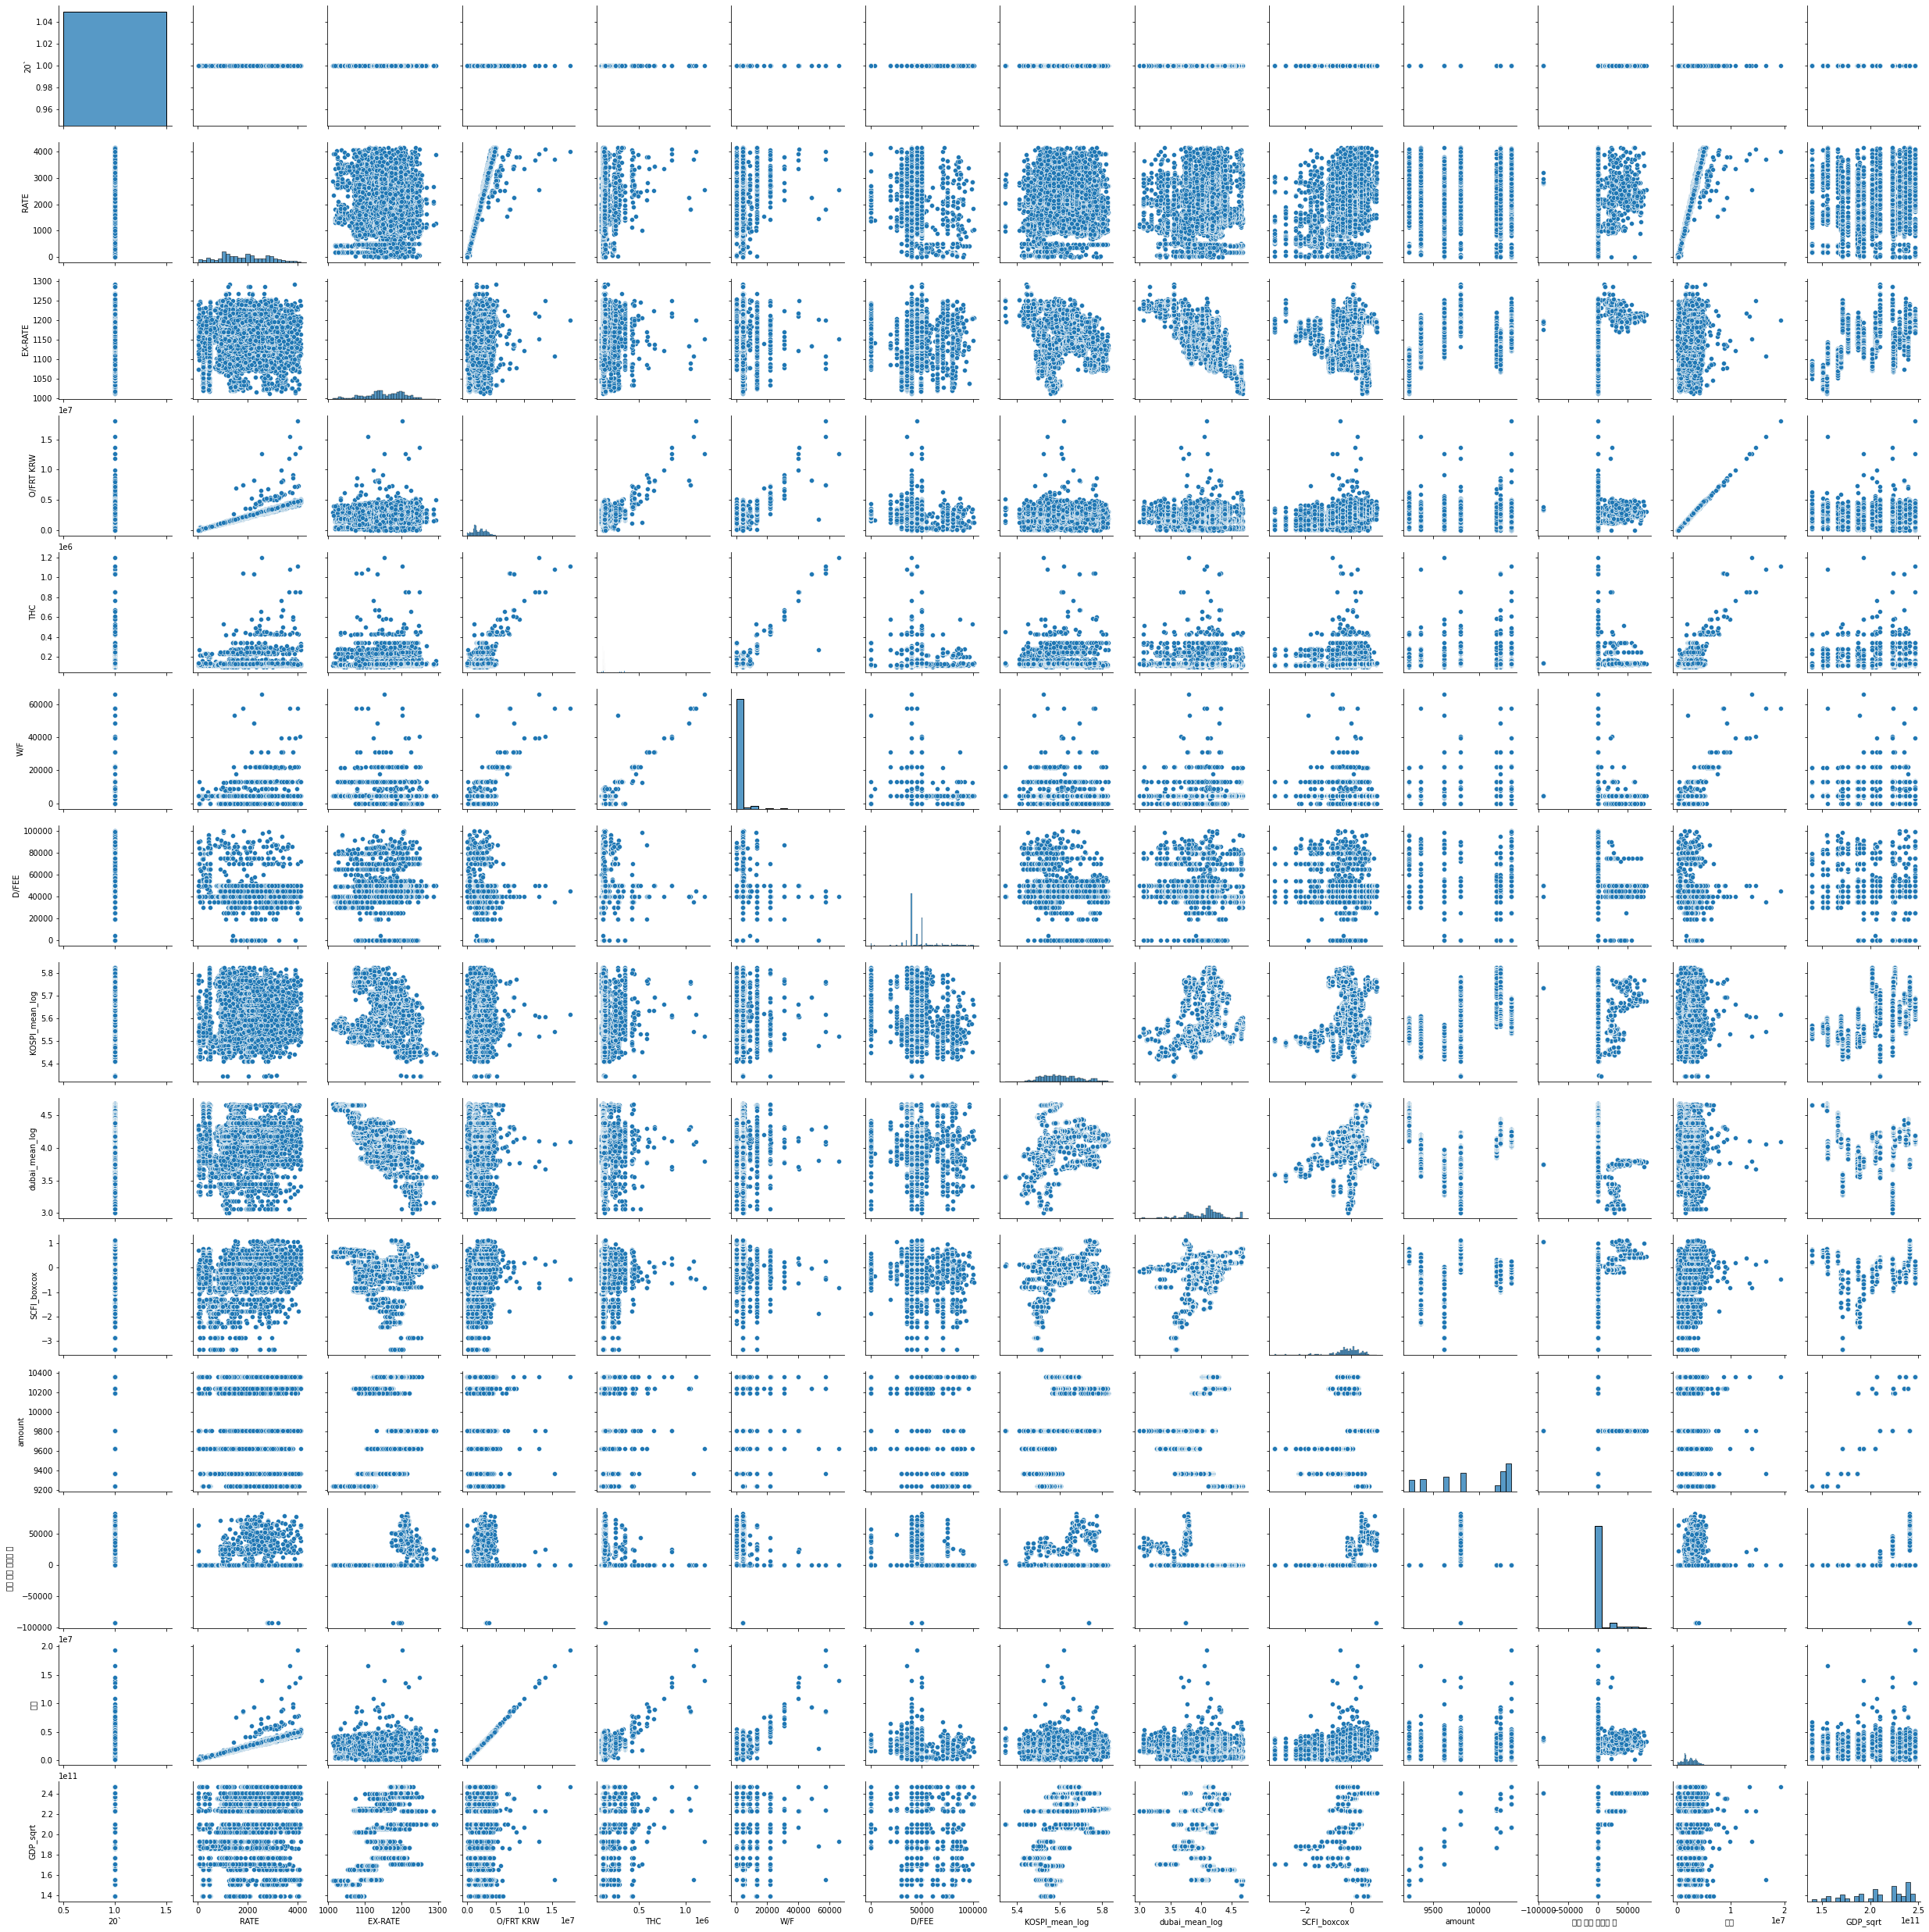

In [110]:
# sns.pairplot([top_10_logistic_cost_dup['20`'], top_10_logistic_cost_dup['RATE'], 
#               top_10_logistic_cost_dup['EX-RATE'], top_10_logistic_cost_dup['O/FRT KRW'], 
#               top_10_logistic_cost_dup['THC'], top_10_logistic_cost_dup['W/F'], top_10_logistic_cost_dup['D/FEE'],
#               top_10_logistic_cost_dup['합계'], top_10_logistic_cost_dup['amount'],
#               top_10_logistic_cost_dup['일별 신규 확진자 수'], top_10_logistic_cost_dup['SCFI_boxcox'],
#               top_10_logistic_cost_dup['KOSPI_mean_log'], top_10_logistic_cost_dup['dubai_mean_log'],
#               top_10_logistic_cost_dup['GDP_sqrt']], diag_kind='hist')

sns.pairplot(top_10_logistic_cost_dup) #????
plt.show()

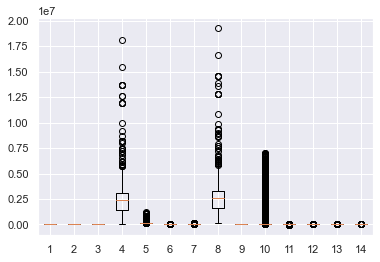

In [119]:
plt.boxplot([data['20`'], data['RATE'], data['EX-RATE'], data['O/FRT KRW'], data['THC'],
             data['W/F'], data['D/FEE'], data['합계'], data['amount'], data['국가별 확진자 수'], data['일별 신규 확진자 수'], data['SCFI_boxcox'], data['SCFI_boxcox'], data['dubai_log']])
plt.show()

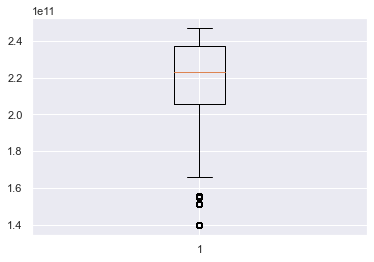

In [121]:
plt.boxplot(data['GDP_sqrt'])
plt.show()

In [114]:
# get the numeric values
numeric_features = data.dtypes[data.dtypes != "object"].index
numeric_features

Index(['20`', 'RATE', 'EX-RATE', 'O/FRT KRW', 'THC', 'W/F', 'D/FEE', '합계',
       'amount', '국가별 확진자 수', '일별 신규 확진자 수', 'SCFI_boxcox', 'kospi_log',
       'dubai_log', 'GDP_sqrt'],
      dtype='object')

In [115]:
skewed_feats = data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSekw in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Sekw in numerical features: 



,Skew
W/F,7.535895
THC,6.728197
국가별 확진자 수,4.963897
일별 신규 확진자 수,3.542203
합계,1.571383
O/FRT KRW,1.313763
D/FEE,0.334502
RATE,0.090558
kospi_log,0.082353
20`,0.000000


In [116]:
corr = data.corr(method = 'pearson')
print(corr)

             20`      RATE   EX-RATE  O/FRT KRW       THC       W/F     D/FEE  \
20`          NaN       NaN       NaN        NaN       NaN       NaN       NaN   
RATE         NaN  1.000000  0.071768   0.940791  0.122352  0.102803 -0.178015   
EX-RATE      NaN  0.071768  1.000000   0.155876  0.092620 -0.046768  0.196493   
O/FRT KRW    NaN  0.940791  0.155876   1.000000  0.341234  0.322330 -0.141017   
THC          NaN  0.122352  0.092620   0.341234  1.000000  0.626308 -0.062804   
W/F          NaN  0.102803 -0.046768   0.322330  0.626308  1.000000  0.011360   
D/FEE        NaN -0.178015  0.196493  -0.141017 -0.062804  0.011360  1.000000   
합계           NaN  0.928846  0.159479   0.998801  0.385921  0.350425 -0.132120   
amount       NaN  0.143293  0.123439   0.139641 -0.009240 -0.034985 -0.064121   
국가별 확진자 수    NaN  0.120392  0.156668   0.123513  0.014693 -0.035975  0.046292   
일별 신규 확진자 수  NaN  0.094010  0.197160   0.103465  0.020677 -0.038238  0.056572   
SCFI_boxcox  NaN  0.292014  

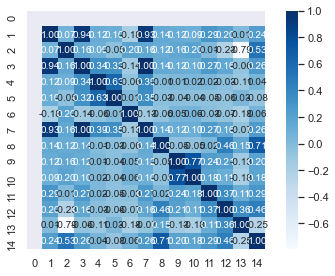

In [117]:
sns.set(font_scale = 1.0)
hm = sns.heatmap(corr.values,
                cbar = True,
                annot = True,
                square = True,
                fmt = '.2f',
                annot_kws = {'size' : 10},
                cmap='Blues')
plt.tight_layout()
plt.show()